In [1]:
import pandas as pd
import re

from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

from pprint import pprint

[nltk_data] Downloading package stopwords to /home/ivan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
papers = pd.read_csv("NIPS Papers/papers.csv")
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


Data processing:
* removing unnecessary columns
* cleaning data from punctuation, string-terminal symbols and other obvious waste
* words lowercasing
* lemmatization (to be done)

In [3]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(512)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
2352,2006,Logistic Regression for Single Trial EEG Class...,Abstract Missing,Logistic Regression for Single Trial EEG\nClas...
6164,2016,Algorithms and matching lower bounds for appro...,"In recent years, a rapidly increasing number o...",Algorithms and matching lower bounds for\nappr...
4878,2014,Deep Learning Face Representation by Joint Ide...,The key challenge of face recognition is to de...,Deep Learning Face Representation by Joint\nId...
1959,2005,Spectral Bounds for Sparse PCA: Exact and Gree...,Abstract Missing,Spectral Bounds for Sparse PCA:\nExact and Gre...
3264,2010,Penalized Principal Component Regression on Gr...,Network models are widely used to capture inte...,Penalized Principal Component Regression on\nG...


In [4]:
data = papers['paper_text'].values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

#Remove single letter words
data = [re.sub(r'\b\w\b', '', sent) for sent in data]

<>:4: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
/tmp/ipykernel_789146/68588412.py:4: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]
/tmp/ipykernel_789146/68588412.py:7: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]


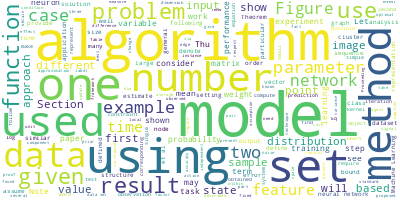

In [6]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(','.join(data))

# Visualize the word cloud
wordcloud.to_image()

In [7]:
#stop words removing

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['logistic', 'regression', 'single', 'trial', 'eeg', 'classification', 'ryota', 'tomioka', 'kazuyuki', 'aihara', 'dept', 'mathematical', 'informatics', 'ist', 'university', 'tokyo', 'tokyo', 'japan', 'klaus', 'robert', 'uller', 'dept', 'computer', 'science', 'technical', 'university', 'berlin', 'franklinstr', 'berlin', 'germany']


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 3), (3, 1), (4, 2), (5, 5), (6, 1), (7, 3), (8, 2), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 5), (23, 2), (24, 1), (25, 3), (26, 3), (27, 1), (28, 1), (29, 1)]


In [9]:
# number of topics
num_topics = 11

# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,                                     
    id2word=id2word,                     
    num_topics=num_topics)

# Print the Keyword in the num_topics topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"data" + 0.007*"model" + 0.007*"learning" + 0.006*"algorithm" + '
  '0.005*"function" + 0.004*"set" + 0.004*"using" + 0.004*"figure" + '
  '0.004*"used" + 0.004*"one"'),
 (1,
  '0.006*"data" + 0.006*"algorithm" + 0.005*"learning" + 0.005*"model" + '
  '0.004*"one" + 0.004*"function" + 0.004*"using" + 0.004*"number" + '
  '0.004*"set" + 0.004*"training"'),
 (2,
  '0.007*"model" + 0.005*"data" + 0.005*"learning" + 0.005*"function" + '
  '0.004*"one" + 0.004*"using" + 0.004*"algorithm" + 0.004*"time" + '
  '0.004*"matrix" + 0.004*"number"'),
 (3,
  '0.007*"learning" + 0.007*"data" + 0.006*"algorithm" + 0.005*"model" + '
  '0.004*"set" + 0.004*"using" + 0.004*"time" + 0.004*"models" + '
  '0.004*"network" + 0.003*"function"'),
 (4,
  '0.007*"learning" + 0.006*"algorithm" + 0.006*"model" + 0.005*"set" + '
  '0.005*"data" + 0.004*"function" + 0.004*"time" + 0.004*"two" + '
  '0.003*"using" + 0.003*"problem"'),
 (5,
  '0.007*"model" + 0.006*"learning" + 0.005*"algorithm" + 0.005

In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/ivan/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005731  0.003880       1        1  17.056714
3      0.000403  0.004568       2        1  14.663773
4      0.000820 -0.003404       3        1  14.124811
0      0.002182  0.003199       4        1  12.995576
6      0.001186  0.000466       5        1   9.062412
7      0.004544  0.000366       6        1   8.048129
10    -0.004326 -0.003671       7        1   7.470553
9      0.001199 -0.000233       8        1   4.865775
5      0.000836 -0.003043       9        1   4.793381
1      0.003292 -0.001096      10        1   3.868736
8     -0.004405 -0.001032      11        1   3.050140, topic_info=          Term         Freq        Total Category  logprob  loglift
182       data  6800.000000  6800.000000  Default  30.0000  30.0000
18   algorithm  5759.000000  5759.000000  Default  29.0000  29.0000
419   learning  7272.000000  7272.000000  Default  28.0000  28.0000
480      model  7144.000000  7144.000000  Default  27.0000  27.0000
687        set  5052.000000  5052.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
322      given    81.053564  2999.531998  Topic11  -6.0840  -0.1211
22        also    81.745214  3077.572723  Topic11  -6.0755  -0.1383
815       used    83.334683  3238.373820  Topic11  -6.0562  -0.1700
307   function    89.936292  4780.196152  Topic11  -5.9800  -0.4832
456     matrix    80.417724  2965.901184  Topic11  -6.0919  -0.1177

[975 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
28128      1  0.147408  abibc
28128      2  0.147408  abibc
28128      3  0.147408  abibc
28128      4  0.147408  abibc
28128      5  0.147408  abibc
...      ...       ...    ...
11827      6  0.105583    zjc
11827      7  0.105583    zjc
11827      8  0.158374    zjc
11827      9  0.052791    zjc
11827     10  0.052791    zjc

[4745 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 7, 8, 11, 10, 6, 2, 9])